<p> Julia Merta </p>
<p> Projekt Uczenie maszynowe w Colabie </p>
<p> Zbiór danych Warzywa i owoce </p>

In [14]:
# Import bibliotek
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn.metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import seaborn as sns
import pandas 
from keras import models
from sklearn.datasets import load_sample_image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [15]:
# Połączenie z dyskiem Google
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Wczytanie zbioru danych, zbiór jest domyślnie podzielony na zbiór testowy, treningowy i walidacyjny.

In [182]:
batch_size = 10
img_height = 224
img_width = 224
train_path='/content/drive/MyDrive/ProjektColab/train/'
val_path='/content/drive/MyDrive/ProjektColab/validation/'
test_path='/content/drive/MyDrive/ProjektColab/test/'

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3115 files belonging to 36 classes.
Using 2492 files for training.
Found 351 files belonging to 36 classes.
Using 70 files for validation.


Zbiór testowy

In [183]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(img_height, img_width),
    batch_size=batch_size
 )

Found 359 files belonging to 36 classes.


Wyświetlenie informacji o rodzajach owoców


In [18]:
# Wypisz nazwy klas
class_names = train_ds.class_names
print(class_names)

['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


<ipython-input-19-90644bbce3a7>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 3, i + 1)


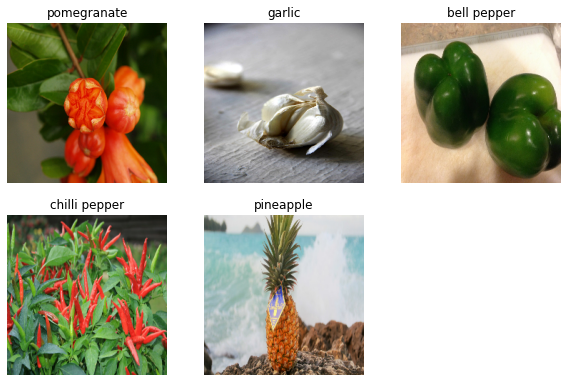

In [19]:
# Wyświetl przykładowe obrazy
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Tensor ma 10 obrazów, o wymiarach 224 na 224 piksele RGB

In [20]:
# Wypisz informację o rodzaju batcha
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch)
  break

(10, 224, 224, 3)
tf.Tensor([12  6  5  1 26 16 32 28  5 19], shape=(10,), dtype=int32)


Normalizacja obrazów i autotune

In [184]:
#autotune
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# normalizacja
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

Budowa pierwszej sieci konwulcyjnej funkcja aktywacji relu

In [22]:
#Budowa modelu rozróżniającego 36 klasy
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Kompilacja pierwszego modelu - ustawienie learning rate i zapis wag modelu jako callback

In [23]:
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [24]:
# Zapis modelu
# !pip install pyyaml h5py  # Required to save models in HDF5 format
checkpoint_path = '/content/drive/MyDrive/ProjektColab/Weights/'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


Zastosowanie wczesnego zatrzymania

In [25]:
# implementacja metody regularyzacji przez wczesne zatrzymanie
# - śledzi najlepsze wagi i przywoła je po zatrzymaniu
earlystopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='loss')

In [26]:
# trenowanie modelu
epochs=10;
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[cp_callback, earlystopping_cb]
)

Epoch 1/10
248/250 [============================>.] - ETA: 0s - loss: 3.1989 - accuracy: 0.1104
Epoch 1: saving model to /content/drive/MyDrive/ProjektColab/Weights/
250/250 [==============================] - 81s 128ms/step - loss: 3.1945 - accuracy: 0.1104 - val_loss: 2.4473 - val_accuracy: 0.3000
Epoch 2/10
249/250 [============================>.] - ETA: 0s - loss: 2.4784 - accuracy: 0.2683
Epoch 2: saving model to /content/drive/MyDrive/ProjektColab/Weights/
250/250 [==============================] - 3s 14ms/step - loss: 2.4768 - accuracy: 0.2685 - val_loss: 1.8048 - val_accuracy: 0.4286
Epoch 3/10
246/250 [============================>.] - ETA: 0s - loss: 2.0423 - accuracy: 0.4046
Epoch 3: saving model to /content/drive/MyDrive/ProjektColab/Weights/
250/250 [==============================] - 3s 14ms/step - loss: 2.0383 - accuracy: 0.4077 - val_loss: 1.3314 - val_accuracy: 0.5857
Epoch 4/10
246/250 [============================>.] - ETA: 0s - loss: 1.4467 - accuracy: 0.5653
Epoch 4:

In [27]:
# Zapis modelu c.d.
os.listdir(checkpoint_dir)

['.data-00000-of-00001', '.index', 'checkpoint']

In [28]:
model.save_weights('/content/drive/MyDrive/ProjektColab/Weights/')

In [29]:
model.save('/content/drive/MyDrive/ProjektColab/Model/')

Wyświetlenie wykresu historii 

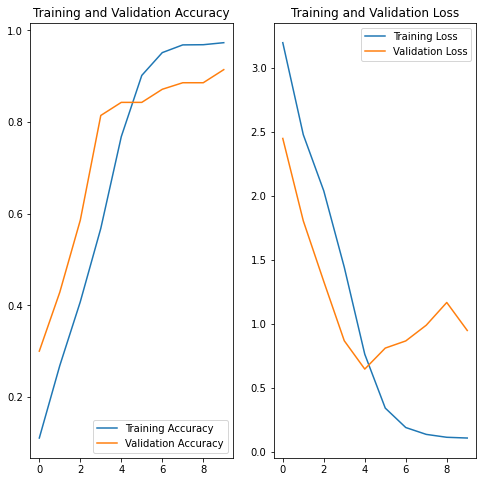

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
#Ewaluacja modelu
model.evaluate(test_ds)

36/36 [==============================] - 116s 2s/step - loss: 0.8639 - accuracy: 0.8774


[0.8639340996742249, 0.8774373531341553]

Drugi model - zmiana funkcji aktywacji - funkcja sigmoidalna, zmiana architektury sieci

In [164]:
#Budowa modelu rozróżniającego 36 klas
num_classes = len(class_names)

model2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='sigmoid'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='sigmoid'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='sigmoid'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='sigmoid'),
  tf.keras.layers.Dense(num_classes)
])

Optymalizator Adam, sparse categorical crossentropy

In [165]:
model2.compile(
  optimizer=keras.optimizers.Adam(),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [166]:
# trenowanie modelu
history2=model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=65
)

Epoch 1/65
250/250 [==============================] - 47s 180ms/step - loss: 3.6587 - accuracy: 0.0257 - val_loss: 3.6413 - val_accuracy: 0.0286
Epoch 2/65
250/250 [==============================] - 46s 180ms/step - loss: 3.6164 - accuracy: 0.0261 - val_loss: 3.6271 - val_accuracy: 0.0286
Epoch 3/65
250/250 [==============================] - 47s 183ms/step - loss: 3.6069 - accuracy: 0.0293 - val_loss: 3.6302 - val_accuracy: 0.0286
Epoch 4/65
250/250 [==============================] - 53s 207ms/step - loss: 3.5959 - accuracy: 0.0321 - val_loss: 3.6205 - val_accuracy: 0.0143
Epoch 5/65
250/250 [==============================] - 46s 179ms/step - loss: 3.5913 - accuracy: 0.0285 - val_loss: 3.6001 - val_accuracy: 0.0571


KeyboardInterrupt: ignored

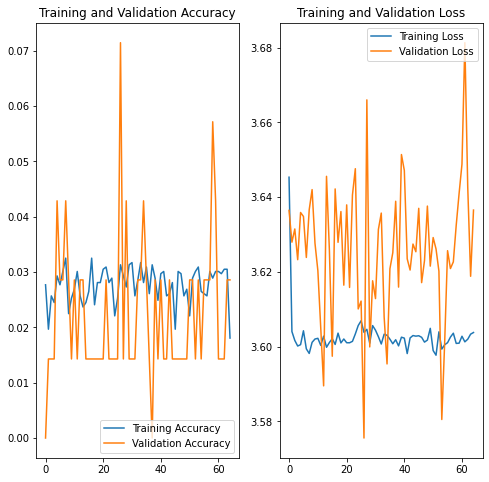

In [35]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(65)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
#Ewaluacja modelu
model2.evaluate(test_ds)

36/36 [==============================] - 8s 181ms/step - loss: 3.6011 - accuracy: 0.0279


[3.601076364517212, 0.027855154126882553]

Trzeci model - funkcja aktywacji: relu; optymalizator: adam; loss: SparseCategoricalCrossentropy 

In [63]:
#Budowa modelu rozróżniającego 36 klas
num_classes = len(class_names)

model3 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [64]:
model3.compile(
  optimizer=keras.optimizers.Adam(),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [65]:
# trenowanie modelu
history3=model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
250/250 [==============================] - 3s 12ms/step - loss: 3.3144 - accuracy: 0.0815 - val_loss: 2.7712 - val_accuracy: 0.1571
Epoch 2/30
250/250 [==============================] - 3s 11ms/step - loss: 2.6204 - accuracy: 0.2356 - val_loss: 2.1875 - val_accuracy: 0.2714
Epoch 3/30
250/250 [==============================] - 3s 11ms/step - loss: 2.2551 - accuracy: 0.3178 - val_loss: 1.7670 - val_accuracy: 0.3571
Epoch 4/30
250/250 [==============================] - 3s 11ms/step - loss: 1.9643 - accuracy: 0.4109 - val_loss: 1.3691 - val_accuracy: 0.6714
Epoch 5/30
250/250 [==============================] - 3s 11ms/step - loss: 1.6816 - accuracy: 0.4872 - val_loss: 1.1358 - val_accuracy: 0.6714
Epoch 6/30
250/250 [==============================] - 3s 12ms/step - loss: 1.4095 - accuracy: 0.5726 - val_loss: 0.9932 - val_accuracy: 0.8000
Epoch 7/30
250/250 [==============================] - 3s 12ms/step - loss: 1.1452 - accuracy: 0.6489 - val_loss: 1.0586 - val_accuracy: 0.7429

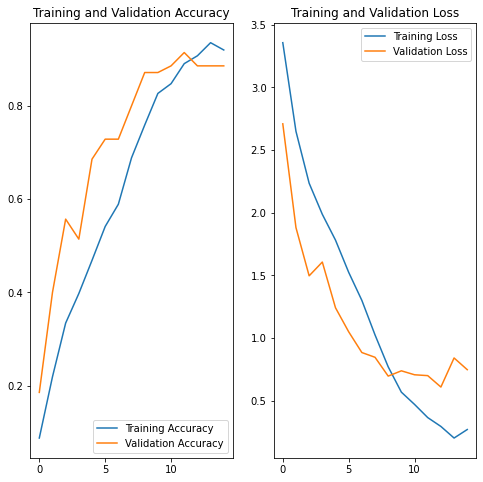

In [40]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
#Ewaluacja modelu
model3.evaluate(test_ds)

36/36 [==============================] - 8s 181ms/step - loss: 0.8556 - accuracy: 0.8301


[0.8556384444236755, 0.8300835490226746]

Model 4 - różne funkcje aktywacji w sieci, model ma bardzo niską dokładność

In [42]:
#Budowa modelu rozróżniającego 36 klas
num_classes = len(class_names)

model4 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='sigmoid'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='sigmoid'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='sigmoid'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, padding='same', activation='sigmoid'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [43]:
model4.compile(
  optimizer=keras.optimizers.Nadam(),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [44]:
# trenowanie modelu - inna funkcja aktywacji dla warstwy konwulcyjnej, jak widać model nie działa dobrze
history4=model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
250/250 [==============================] - 5s 15ms/step - loss: 3.8319 - accuracy: 0.0261 - val_loss: 3.5865 - val_accuracy: 0.0143
Epoch 2/50
250/250 [==============================] - 4s 15ms/step - loss: 3.5821 - accuracy: 0.0353 - val_loss: 3.5889 - val_accuracy: 0.0143
Epoch 3/50
250/250 [==============================] - 4s 14ms/step - loss: 3.5810 - accuracy: 0.0353 - val_loss: 3.5916 - val_accuracy: 0.0143
Epoch 4/50
250/250 [==============================] - 4s 15ms/step - loss: 3.5801 - accuracy: 0.0353 - val_loss: 3.5938 - val_accuracy: 0.0143
Epoch 5/50
250/250 [==============================] - 4s 15ms/step - loss: 3.5795 - accuracy: 0.0353 - val_loss: 3.5958 - val_accuracy: 0.0143
Epoch 6/50
250/250 [==============================] - 4s 14ms/step - loss: 3.5789 - accuracy: 0.0353 - val_loss: 3.5977 - val_accuracy: 0.0143
Epoch 7/50
250/250 [==============================] - 4s 15ms/step - loss: 3.5786 - accuracy: 0.0353 - val_loss: 3.5994 - val_accuracy: 0.0143

In [45]:
#Ewaluacja modelu
model4.evaluate(test_ds)

36/36 [==============================] - 8s 179ms/step - loss: 3.5904 - accuracy: 0.0279


[3.590423107147217, 0.027855154126882553]

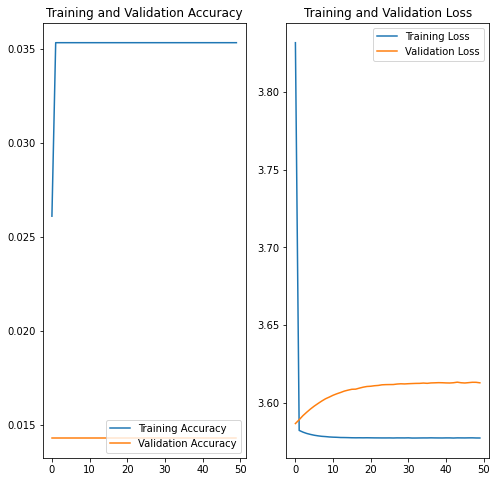

In [46]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model 5 - optymalizator momentum funkcja aktywacji relu, optymalizator SGD, loss - sparse categorical crossentropy

In [47]:
#Budowa modelu rozróżniającego 36 klas
num_classes = len(class_names)

model5 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [48]:
model5.compile(
  optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.6),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [49]:
# trenowanie modelu
history5=model5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
250/250 [==============================] - 3s 12ms/step - loss: 3.5729 - accuracy: 0.0425 - val_loss: 3.4831 - val_accuracy: 0.1000
Epoch 2/50
250/250 [==============================] - 3s 10ms/step - loss: 3.3030 - accuracy: 0.0770 - val_loss: 3.3076 - val_accuracy: 0.1000
Epoch 3/50
250/250 [==============================] - 3s 10ms/step - loss: 3.0457 - accuracy: 0.1144 - val_loss: 2.5772 - val_accuracy: 0.2143
Epoch 4/50
250/250 [==============================] - 3s 11ms/step - loss: 2.7888 - accuracy: 0.1806 - val_loss: 2.2498 - val_accuracy: 0.3429
Epoch 5/50
250/250 [==============================] - 3s 11ms/step - loss: 2.5124 - accuracy: 0.2540 - val_loss: 1.9148 - val_accuracy: 0.5000
Epoch 6/50
250/250 [==============================] - 3s 11ms/step - loss: 2.2503 - accuracy: 0.3226 - val_loss: 1.5750 - val_accuracy: 0.5429
Epoch 7/50
250/250 [==============================] - 3s 13ms/step - loss: 1.9895 - accuracy: 0.3993 - val_loss: 1.5667 - val_accuracy: 0.5714

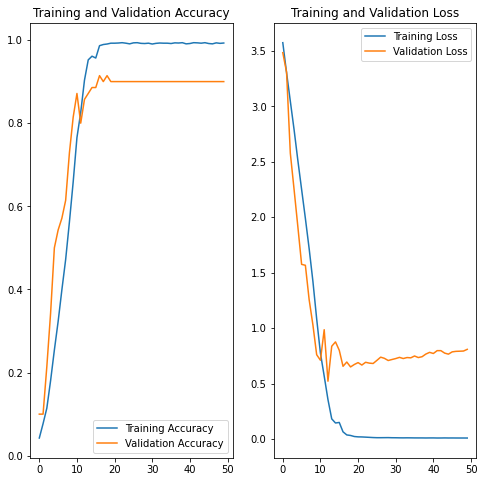

In [50]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
#Ewaluacja modelu
model5.evaluate(test_ds)

36/36 [==============================] - 8s 179ms/step - loss: 0.7996 - accuracy: 0.8858


[0.7995778918266296, 0.8857938647270203]

Transfer learning sieć Xception

In [185]:
  base_model = keras.applications.xception.Xception(weights="imagenet",include_top=False)
  avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
  output = keras.layers.Dense(36, activation='softmax')(avg)
  model6 = keras.Model(inputs=base_model.input, outputs=output)

  model6.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
  history6 = model6.fit(train_ds, epochs=40, validation_data=val_ds)

Epoch 1/40
250/250 [==============================] - 105s 222ms/step - loss: 3.1380 - accuracy: 0.2396 - val_loss: 1.7186 - val_accuracy: 0.7286
Epoch 2/40
250/250 [==============================] - 51s 204ms/step - loss: 1.7811 - accuracy: 0.6677 - val_loss: 0.7064 - val_accuracy: 0.9000
Epoch 3/40
250/250 [==============================] - 51s 204ms/step - loss: 0.9797 - accuracy: 0.8218 - val_loss: 0.4207 - val_accuracy: 0.9000
Epoch 4/40
250/250 [==============================] - 51s 205ms/step - loss: 0.5923 - accuracy: 0.9013 - val_loss: 0.2919 - val_accuracy: 0.9429
Epoch 5/40
250/250 [==============================] - 51s 205ms/step - loss: 0.3802 - accuracy: 0.9498 - val_loss: 0.2564 - val_accuracy: 0.9286
Epoch 6/40
250/250 [==============================] - 51s 205ms/step - loss: 0.2547 - accuracy: 0.9719 - val_loss: 0.2311 - val_accuracy: 0.9429
Epoch 7/40
250/250 [==============================] - 51s 205ms/step - loss: 0.1788 - accuracy: 0.9831 - val_loss: 0.2211 - val_a

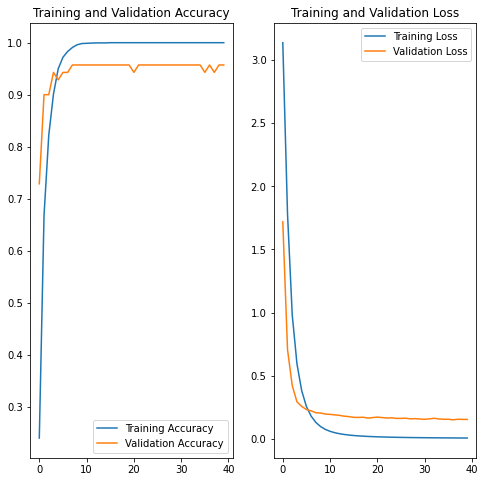

In [187]:
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']
loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [188]:
model6.evaluate(test_ds)

36/36 [==============================] - 10s 191ms/step - loss: 0.1709 - accuracy: 0.9471


[0.17085540294647217, 0.9470751881599426]

In [199]:
labels = list(test_ds.class_names)

In [211]:
base_model = keras.applications.xception.Xception(weights="imagenet",include_top=False)
layer = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(36, activation='softmax')(layer)
model8 = keras.Model(inputs=base_model.input, outputs=output)

model8.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history8 = model8.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
250/250 [==============================] - 54s 197ms/step - loss: 3.1397 - accuracy: 0.2588 - val_loss: 1.8303 - val_accuracy: 0.7286
Epoch 2/10
250/250 [==============================] - 50s 200ms/step - loss: 1.7734 - accuracy: 0.6778 - val_loss: 0.7482 - val_accuracy: 0.9000
Epoch 3/10
250/250 [==============================] - 51s 206ms/step - loss: 0.9759 - accuracy: 0.8250 - val_loss: 0.4458 - val_accuracy: 0.9000
Epoch 4/10
250/250 [==============================] - 51s 204ms/step - loss: 0.5939 - accuracy: 0.9041 - val_loss: 0.3450 - val_accuracy: 0.9143
Epoch 5/10
250/250 [==============================] - 51s 204ms/step - loss: 0.3811 - accuracy: 0.9450 - val_loss: 0.2755 - val_accuracy: 0.9286
Epoch 6/10
250/250 [==============================] - 51s 205ms/step - loss: 0.2562 - accuracy: 0.9687 - val_loss: 0.2582 - val_accuracy: 0.9286
Epoch 7/10
250/250 [==============================] - 51s 204ms/step - loss: 0.1793 - accuracy: 0.9815 - val_loss: 0.2369 - val_ac

Macierz pomyłek

In [213]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plotConfusionMatrix(model):
  y_pred = []
  y_true = []

  for image_batch, label_batch in test_ds:
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis = -1))

  ground_truth_labels = np.array(tf.concat([item for item in y_true], axis = 0))
  predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

  confusionMatrix = confusion_matrix(ground_truth_labels, predicted_labels)
  confusion_matrix_display = ConfusionMatrixDisplay(confusionMatrix, display_labels=class_names)
  fig, ax = plt.subplots(figsize=(40,40), dpi=100)
  confusion_matrix_display.plot(ax=ax, xticks_rotation='vertical')

1/1 [==============================] - 0s 23ms/step


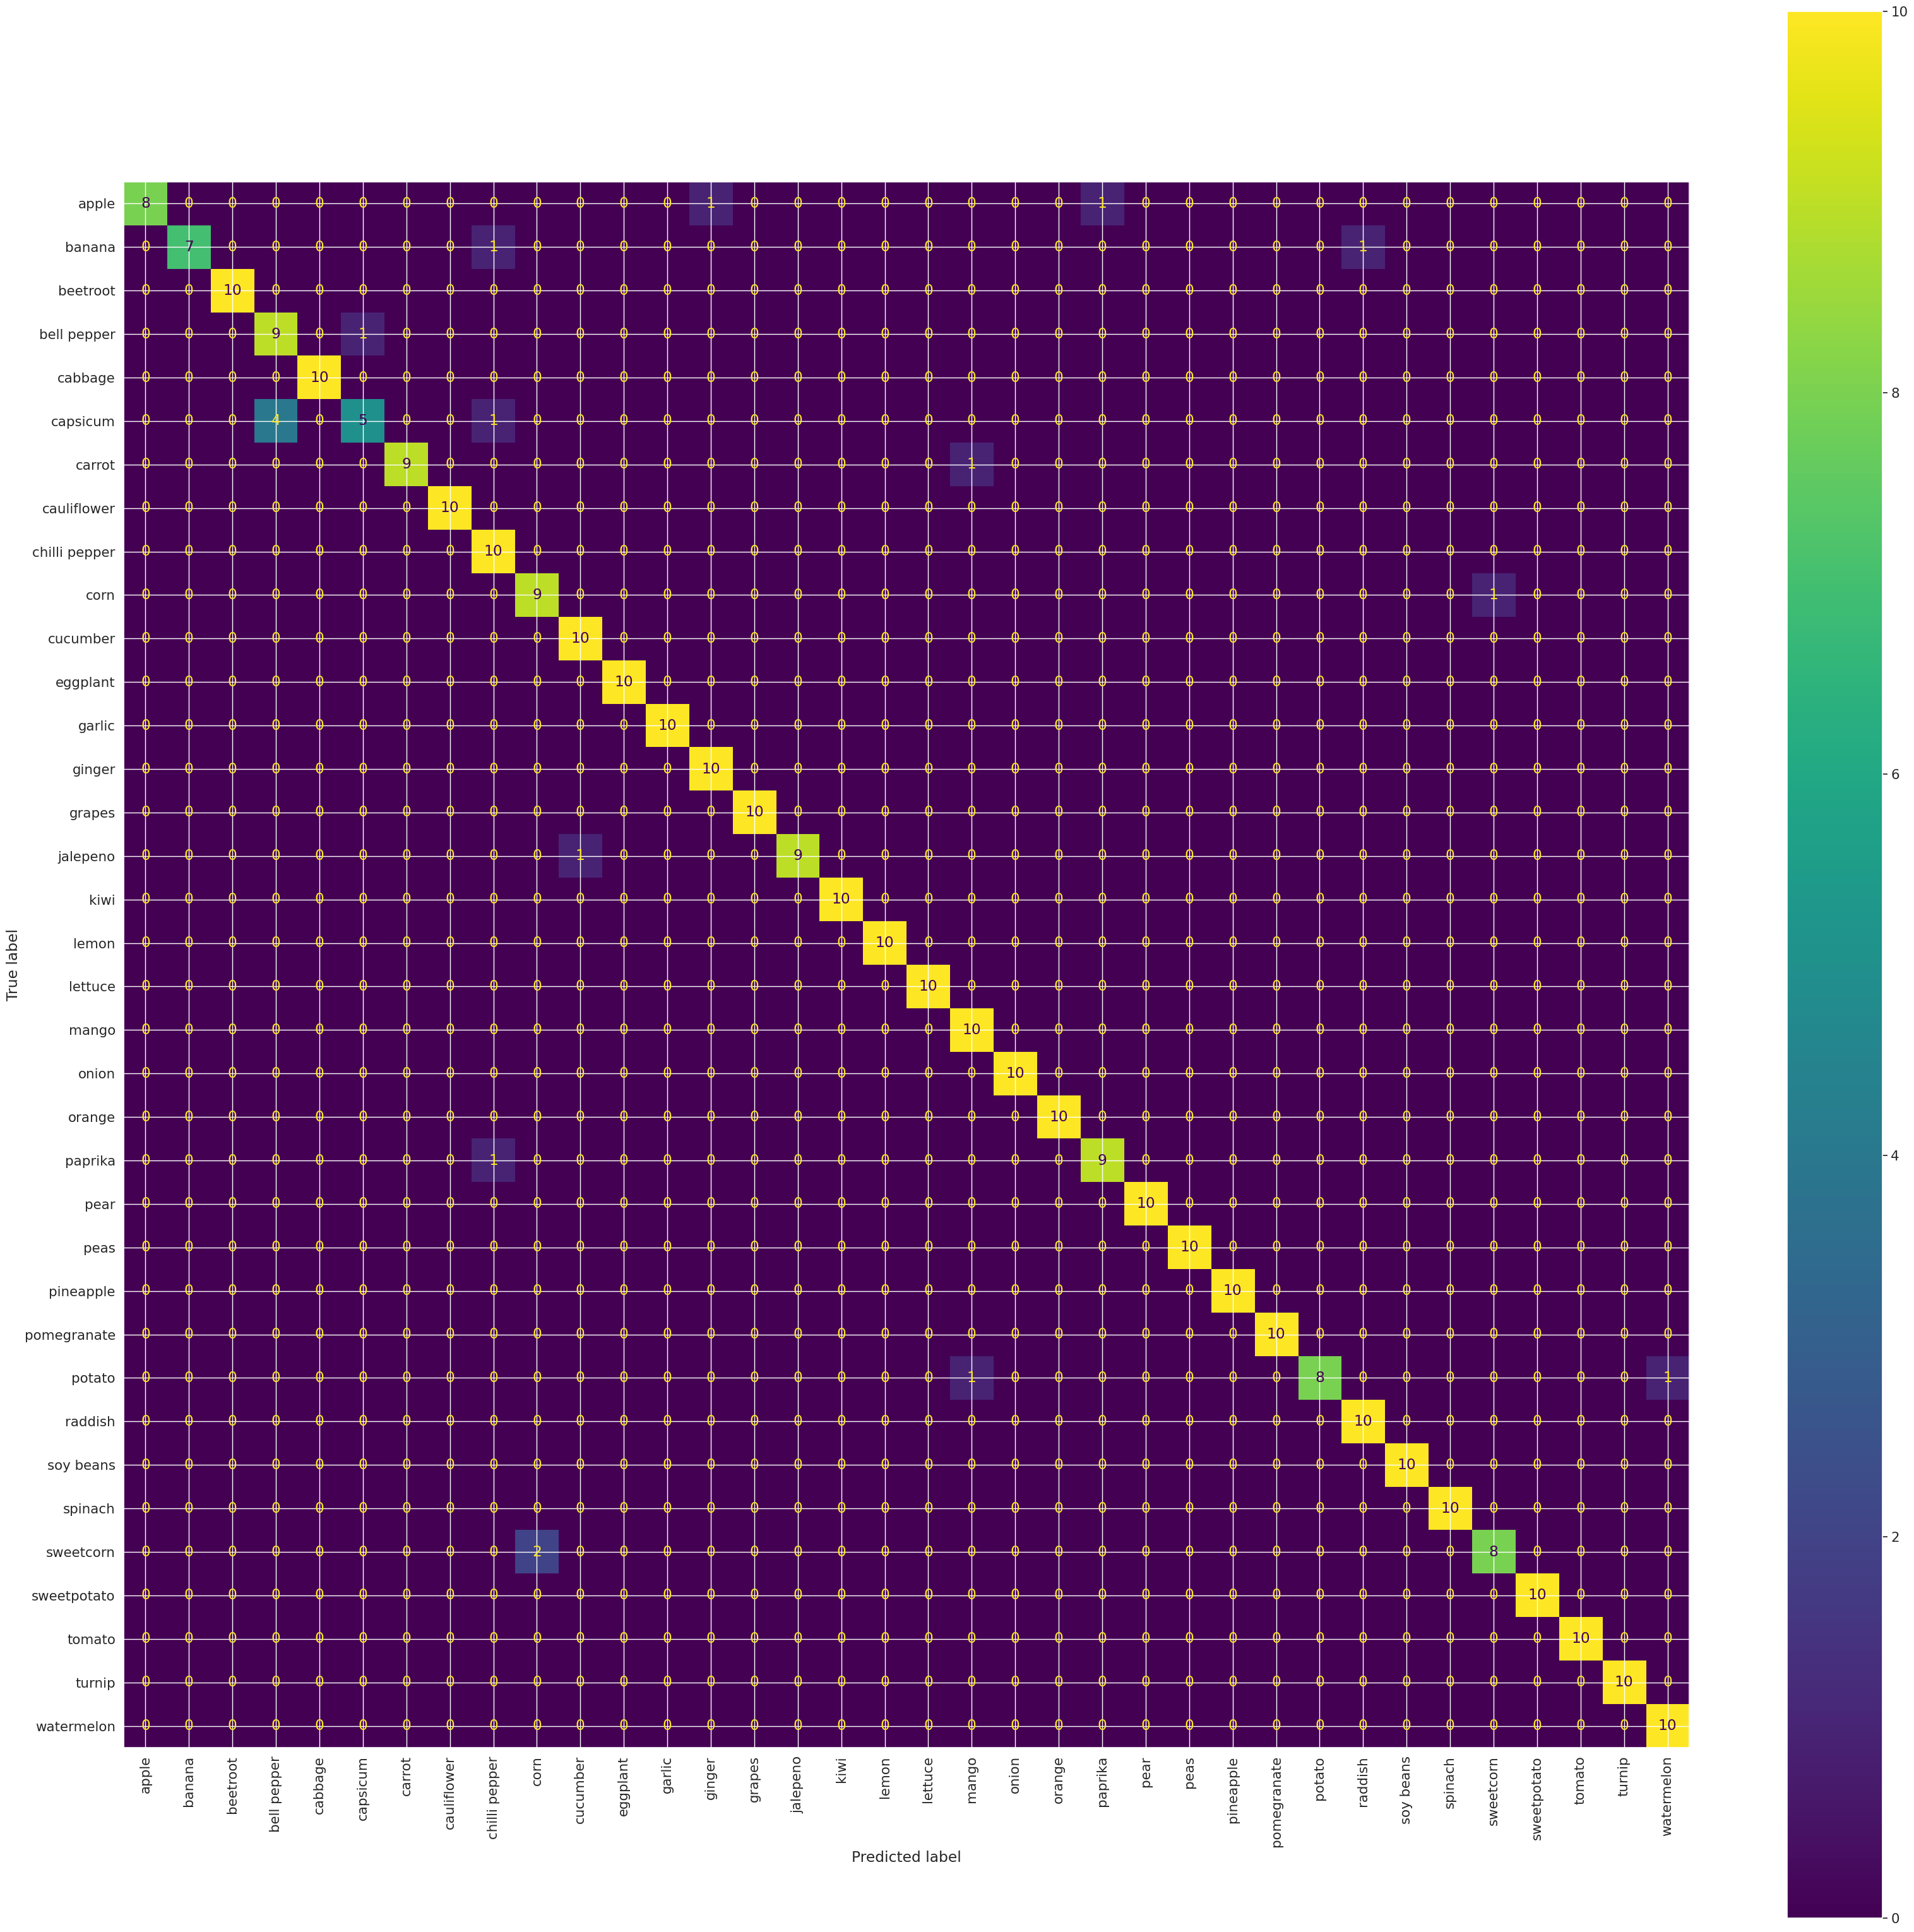

In [214]:
plotConfusionMatrix(model8)

Wnioski: W projekcie przetestowano kilka różnych modeli sieci neuronowych. Największą dokładność uzyskano dla uczenia transferowego z wykorzystaniem sieci Xception. Macierz pomyłek również pokazuje, że model dobrze przewiduje rodzaje warzyw i owoców.